# 1. Environment Setup and Imports
### Import libraries, set device, and define paths and augmentation strategies.

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(".."))
from dataset import create_dataloaders

# Select device: prefer CUDA, then MPS, otherwise CPU
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using device: {device}")

# Define data root and model save directory
data_root = os.path.abspath(os.path.join("..", "Aerial_Landscapes"))
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
augmentation_strategies = ['minimal', 'default', 'extensive']

Using device: mps


# 2. Define Training, Plotting, and Evaluation Functions
### train_model: returns history including batch_losses;
### plot_training_history: three subplots (loss, accuracy, batch loss);
### evaluate: confusion matrix and precision/recall table.

In [4]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    batch_losses = []
    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            batch_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        train_loss_list.append(running_train_loss / len(train_loader))
        train_acc_list.append(correct_train / total_train)
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss_list.append(running_val_loss / len(val_loader))
        val_acc_list.append(correct_val / total_val)
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss_list[-1]:.4f} | Train Acc: {train_acc_list[-1]:.4f} | "
              f"Val Loss: {val_loss_list[-1]:.4f} | Val Acc: {val_acc_list[-1]:.4f}")
    return {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list,
        'batch_losses': batch_losses
    }


def plot_training_history(history, strategy_name):
    plt.figure(figsize=(12, 8))
    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    # Plot loss per batch
    plt.subplot(2, 1, 2)
    plt.plot(history['batch_losses'])
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss per Batch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def evaluate(model, loader, classes, strategy_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({strategy_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Print precision, recall, F1-score table
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    report_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })
    print(f"=== Precision / Recall / F1-score ({strategy_name}) ===")
    display(report_df.style.format({
        'Precision': '{:.3f}',
        'Recall': '{:.3f}',
        'F1-score': '{:.3f}'
    }))

# 3. Train and Save the Best Model


=== Strategy: MINIMAL ===
Epoch 1/10 | Train Loss: 1.0367 | Train Acc: 0.7700 | Val Loss: 0.3304 | Val Acc: 0.8988
Epoch 2/10 | Train Loss: 0.1986 | Train Acc: 0.9494 | Val Loss: 0.2061 | Val Acc: 0.9308
Epoch 3/10 | Train Loss: 0.1038 | Train Acc: 0.9707 | Val Loss: 0.1765 | Val Acc: 0.9446
Epoch 4/10 | Train Loss: 0.0779 | Train Acc: 0.9788 | Val Loss: 0.1485 | Val Acc: 0.9558
Epoch 5/10 | Train Loss: 0.0568 | Train Acc: 0.9850 | Val Loss: 0.1574 | Val Acc: 0.9517
Epoch 6/10 | Train Loss: 0.0433 | Train Acc: 0.9885 | Val Loss: 0.1515 | Val Acc: 0.9567
Epoch 7/10 | Train Loss: 0.0330 | Train Acc: 0.9903 | Val Loss: 0.1476 | Val Acc: 0.9583
Epoch 8/10 | Train Loss: 0.0312 | Train Acc: 0.9915 | Val Loss: 0.1404 | Val Acc: 0.9571
Epoch 9/10 | Train Loss: 0.0206 | Train Acc: 0.9946 | Val Loss: 0.1333 | Val Acc: 0.9621
Epoch 10/10 | Train Loss: 0.0240 | Train Acc: 0.9932 | Val Loss: 0.1615 | Val Acc: 0.9537


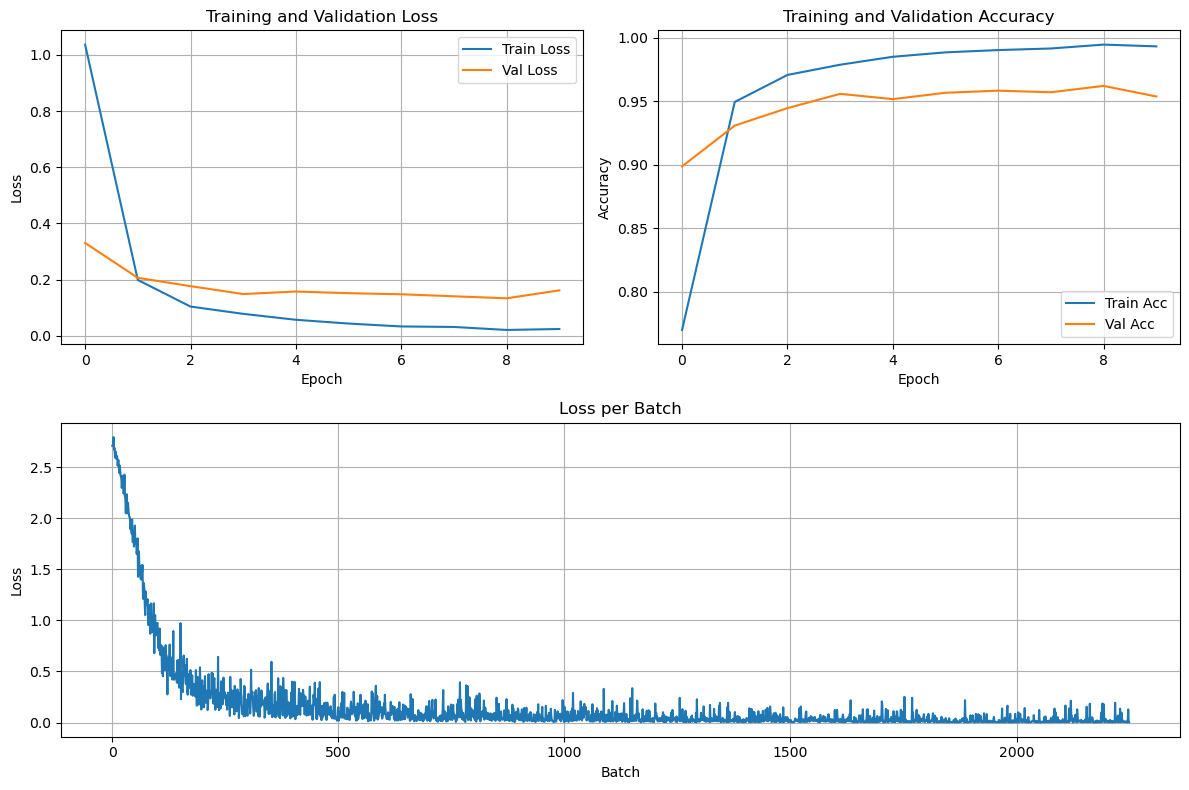

--> New best saved: minimal (Val Acc: 0.9537)

=== Strategy: DEFAULT ===
Epoch 1/10 | Train Loss: 1.2286 | Train Acc: 0.6990 | Val Loss: 0.4084 | Val Acc: 0.8858
Epoch 2/10 | Train Loss: 0.3469 | Train Acc: 0.8990 | Val Loss: 0.2643 | Val Acc: 0.9213
Epoch 3/10 | Train Loss: 0.2242 | Train Acc: 0.9324 | Val Loss: 0.2413 | Val Acc: 0.9221
Epoch 4/10 | Train Loss: 0.1942 | Train Acc: 0.9396 | Val Loss: 0.2001 | Val Acc: 0.9367
Epoch 5/10 | Train Loss: 0.1704 | Train Acc: 0.9465 | Val Loss: 0.1862 | Val Acc: 0.9392
Epoch 6/10 | Train Loss: 0.1360 | Train Acc: 0.9590 | Val Loss: 0.1977 | Val Acc: 0.9371
Epoch 7/10 | Train Loss: 0.1151 | Train Acc: 0.9646 | Val Loss: 0.1706 | Val Acc: 0.9454
Epoch 8/10 | Train Loss: 0.1086 | Train Acc: 0.9671 | Val Loss: 0.1819 | Val Acc: 0.9421
Epoch 9/10 | Train Loss: 0.0945 | Train Acc: 0.9696 | Val Loss: 0.1610 | Val Acc: 0.9533
Epoch 10/10 | Train Loss: 0.0877 | Train Acc: 0.9744 | Val Loss: 0.1540 | Val Acc: 0.9525


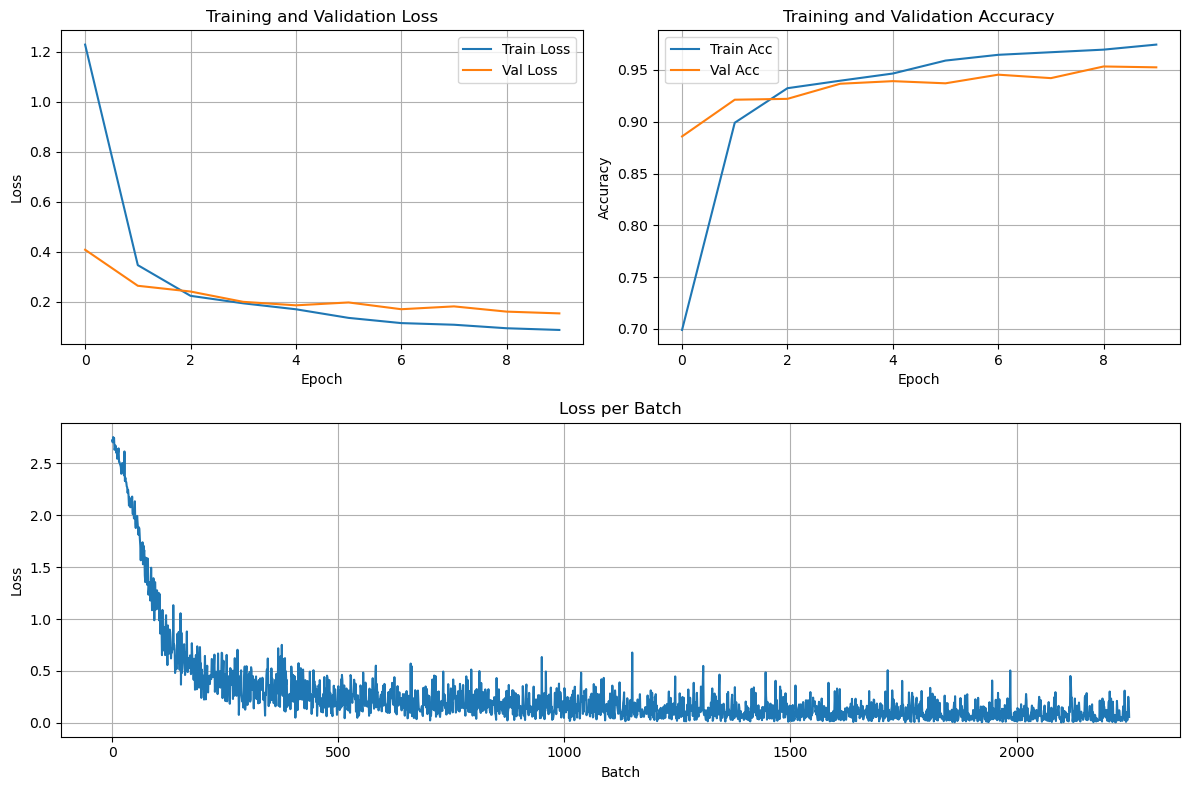


=== Strategy: EXTENSIVE ===
Epoch 1/10 | Train Loss: 1.3862 | Train Acc: 0.6390 | Val Loss: 0.5869 | Val Acc: 0.8479
Epoch 2/10 | Train Loss: 0.4729 | Train Acc: 0.8588 | Val Loss: 0.3576 | Val Acc: 0.8933
Epoch 3/10 | Train Loss: 0.3523 | Train Acc: 0.8896 | Val Loss: 0.3316 | Val Acc: 0.8979
Epoch 4/10 | Train Loss: 0.3130 | Train Acc: 0.9036 | Val Loss: 0.2661 | Val Acc: 0.9200
Epoch 5/10 | Train Loss: 0.2546 | Train Acc: 0.9161 | Val Loss: 0.2581 | Val Acc: 0.9225
Epoch 6/10 | Train Loss: 0.2231 | Train Acc: 0.9314 | Val Loss: 0.2590 | Val Acc: 0.9183
Epoch 7/10 | Train Loss: 0.2017 | Train Acc: 0.9340 | Val Loss: 0.2302 | Val Acc: 0.9308
Epoch 8/10 | Train Loss: 0.1966 | Train Acc: 0.9372 | Val Loss: 0.2102 | Val Acc: 0.9337
Epoch 9/10 | Train Loss: 0.1771 | Train Acc: 0.9419 | Val Loss: 0.2024 | Val Acc: 0.9371
Epoch 10/10 | Train Loss: 0.1614 | Train Acc: 0.9487 | Val Loss: 0.2031 | Val Acc: 0.9358


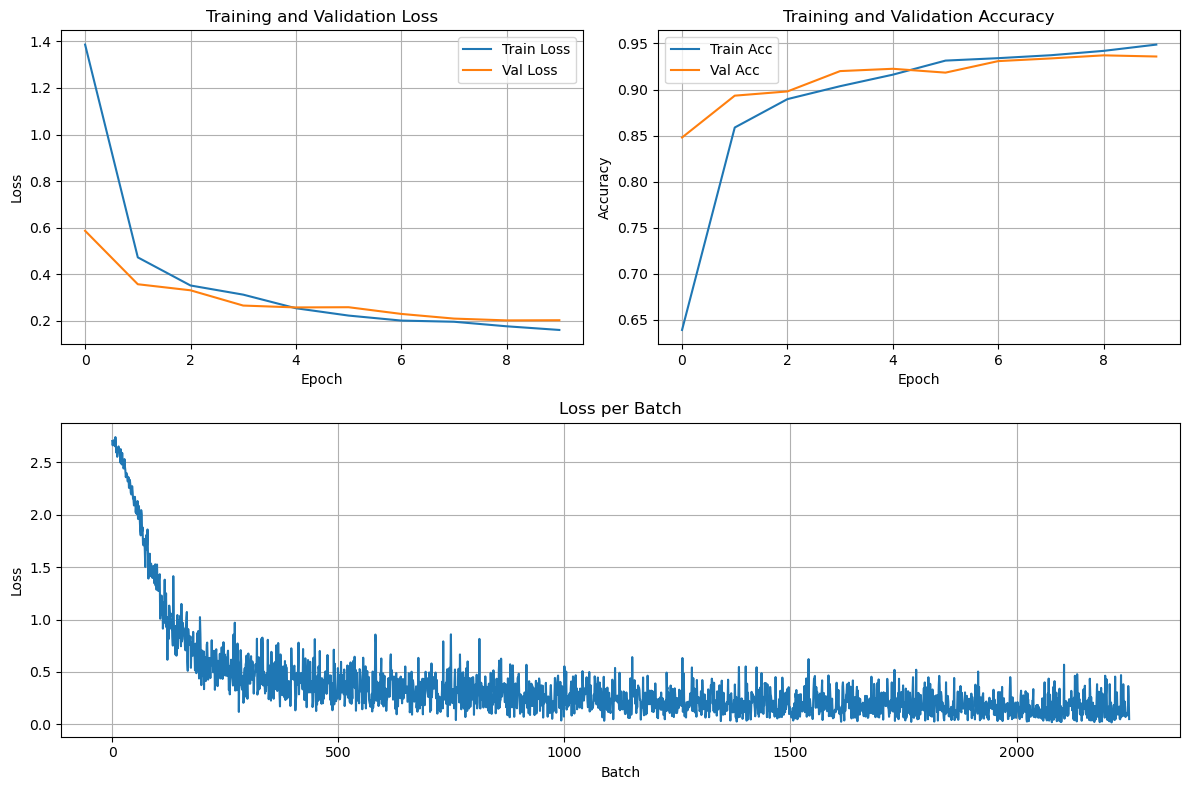


Best strategy: MINIMAL (Val Acc: 0.9537)


In [5]:
best_val_acc = 0.0
best_strategy = None
best_model_path = None
for strategy in augmentation_strategies:
    print(f"\n=== Strategy: {strategy.upper()} ===")
    train_loader, val_loader, test_loader, classes = create_dataloaders(
        root_dir=data_root,
        batch_size=32,
        augmentation_strategy=strategy,
        split_ratio=[0.6,0.2,0.2],
        num_workers=4,
        verbose=False
    )
    # Initialize model and optimizer
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # learning rate set to 0.0001
    # Train and collect history
    history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)
    # Plot training curves
    plot_training_history(history, strategy)
    # Save best model based on validation accuracy
    val_acc = history['val_acc'][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_strategy = strategy
        best_model_path = os.path.join(save_dir, 'best_model.pt')
        torch.save(model.state_dict(), best_model_path)
        print(f"--> New best saved: {strategy} (Val Acc: {val_acc:.4f})")
print(f"\nBest strategy: {best_strategy.upper()} (Val Acc: {best_val_acc:.4f})")

# 4. Load Best Model and Predict on Test Sets


--- Testing: MINIMAL ---


/var/folders/l1/ltbg4p1x2kqcwdlx3my6wn_40000gn/T/ipykernel_83204/1179190742.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

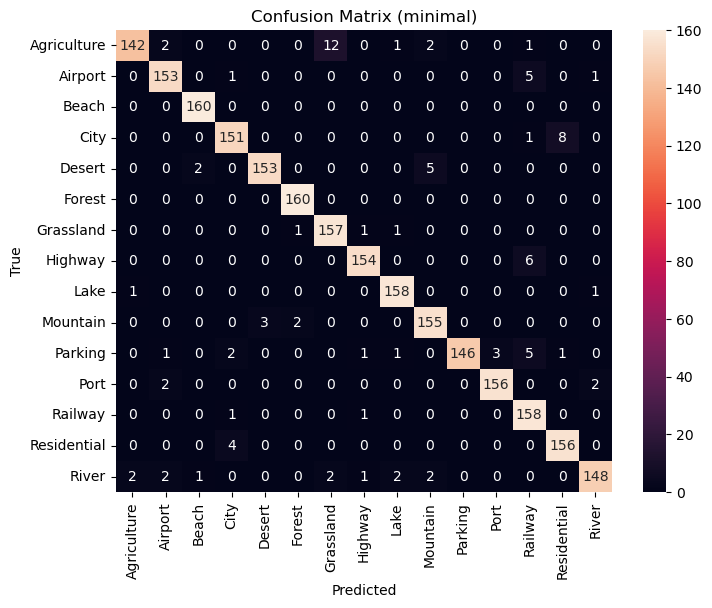

=== Precision / Recall / F1-score (minimal) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.979,0.887,0.931
1,Airport,0.956,0.956,0.956
2,Beach,0.982,1.000,0.991
3,City,0.950,0.944,0.947
4,Desert,0.981,0.956,0.968
5,Forest,0.982,1.000,0.991
6,Grassland,0.918,0.981,0.949
7,Highway,0.975,0.963,0.969
8,Lake,0.969,0.988,0.978
9,Mountain,0.945,0.969,0.957



--- Testing: DEFAULT ---


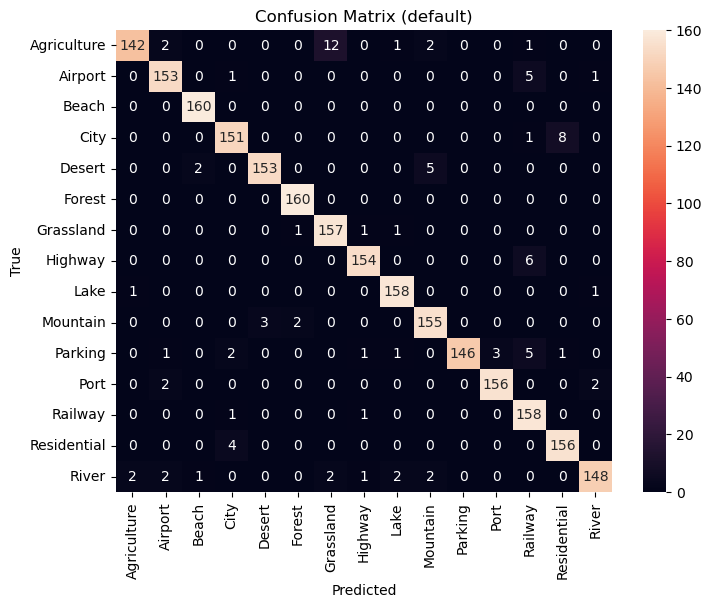

=== Precision / Recall / F1-score (default) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.979,0.887,0.931
1,Airport,0.956,0.956,0.956
2,Beach,0.982,1.000,0.991
3,City,0.950,0.944,0.947
4,Desert,0.981,0.956,0.968
5,Forest,0.982,1.000,0.991
6,Grassland,0.918,0.981,0.949
7,Highway,0.975,0.963,0.969
8,Lake,0.969,0.988,0.978
9,Mountain,0.945,0.969,0.957



--- Testing: EXTENSIVE ---


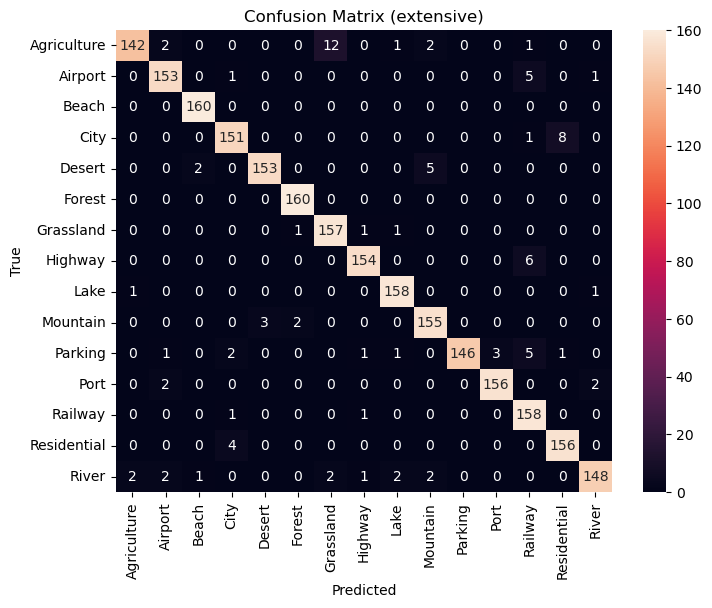

=== Precision / Recall / F1-score (extensive) ===


,Class,Precision,Recall,F1-score
0,Agriculture,0.979,0.887,0.931
1,Airport,0.956,0.956,0.956
2,Beach,0.982,1.000,0.991
3,City,0.950,0.944,0.947
4,Desert,0.981,0.956,0.968
5,Forest,0.982,1.000,0.991
6,Grassland,0.918,0.981,0.949
7,Highway,0.975,0.963,0.969
8,Lake,0.969,0.988,0.978
9,Mountain,0.945,0.969,0.957


In [6]:
# Prepare the best model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)
# Evaluate on each test set with visualization
for strategy in augmentation_strategies:
    print(f"\n--- Testing: {strategy.upper()} ---")
    _, _, test_loader, classes = create_dataloaders(
        root_dir=data_root,
        batch_size=32,
        augmentation_strategy=strategy,
        split_ratio=[0.6,0.2,0.2],
        num_workers=4,
        verbose=False
    )
    evaluate(model, test_loader, classes, strategy)